# Load Data

In [191]:
# Libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [151]:
# cc_info - general information about the credit card and its holder
cc_info = pd.read_csv('.../cc_info.csv')
cc_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [152]:
cc_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
credit_card          984 non-null int64
city                 984 non-null object
state                984 non-null object
zipcode              984 non-null int64
credit_card_limit    984 non-null int64
dtypes: int64(3), object(2)
memory usage: 38.5+ KB


In [153]:
# Information about each transaction that happens between Aug,1 and Oct, 30 for the credit cards in cc_info.
transaction = pd.read_csv('.../transactions.csv'
                         #, parse_dates=['date']
                         )
transaction.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [154]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
credit_card                  294588 non-null int64
date                         294588 non-null object
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.2+ MB


In [155]:
# Check NA in cc_info
cc_info.isnull().sum()

credit_card          0
city                 0
state                0
zipcode              0
credit_card_limit    0
dtype: int64

In [156]:
# Check NA in transaction
transaction.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64

# Senario 1

Identify those users that in your dataset never went above the
monthly credit card limit (Calendar Month). The goal of this is to automatically increase
their limit.

In [157]:
# Split dates into dates and time, and left join with cc_info to include credit card and user info
temp = transaction['date'].str.split(" ", 1, expand = True)
transaction.drop(columns = ['date'], inplace = True)
transaction['date'] = temp[0]
transaction['time'] = temp[1]

transaction['date'] = pd.to_datetime(transaction['date'])
transaction['time'] = pd.to_datetime(transaction['time']).dt.time

df = pd.merge(transaction, cc_info, how = 'left', on = 'credit_card')
df.head(3)

,credit_card,transaction_dollar_amount,Long,Lat,date,time,city,state,zipcode,credit_card_limit
0,1003715054175576,43.78,-80.174132,40.267370,2015-09-11,00:32:40,Houston,PA,15342,20000
1,1003715054175576,103.15,-80.194240,40.180114,2015-10-24,22:23:08,Houston,PA,15342,20000
2,1003715054175576,48.55,-80.211033,40.313004,2015-10-26,18:19:36,Houston,PA,15342,20000


In [158]:
df.date.dt.year.value_counts()  # All transactions happen in 2015

2015    294588
Name: date, dtype: int64

In [159]:
# Build a function to calculate total transaction amount for each user by month
def monthly_amount(data):
    return data.groupby(df.date.dt.month)['transaction_dollar_amount'].agg('sum')

In [160]:
# Apply the function above to df grouped by each credit_card
monthly_spent = df.groupby('credit_card').apply(monthly_amount).reset_index()
monthly_spent.rename(columns = {'date':'month'}, inplace = True)

In [161]:
# Preparation for comparing each credit_card's monthly_spent vs. credit_card_limit
df_compare = monthly_spent.join(cc_info.credit_card_limit)
df_compare.head(3)

,credit_card,month,transaction_dollar_amount,credit_card_limit
0,1003715054175576,7,162.56,6000.0
1,1003715054175576,8,8441.51,16000.0
2,1003715054175576,9,11281.56,14000.0


In [162]:
# Identify the credit_card that exceeds monthly limits, is_exceed = 0 means not exceed, is_exceed = 1 means exceed
df_compare['is_exceed'] = (df_compare['transaction_dollar_amount'] > df_compare['credit_card_limit']).astype(int)
df_compare.head(3)

,credit_card,month,transaction_dollar_amount,credit_card_limit,is_exceed
0,1003715054175576,7,162.56,6000.0,0
1,1003715054175576,8,8441.51,16000.0,0
2,1003715054175576,9,11281.56,14000.0,0


In [163]:
# Output the final credit_card
df_compare_result = df_compare.groupby('credit_card')['is_exceed'].sum().reset_index()
never_exceed = df_compare_result[df_compare_result['is_exceed'] == 0][['credit_card']]
never_exceed.head(3)

,credit_card
0,1003715054175576
3,1073931538936472
4,1077622576192810


# Senario 2

Implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [164]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df.head(3)

,credit_card,transaction_dollar_amount,Long,Lat,date,time,city,state,zipcode,credit_card_limit,year,month,day
0,1003715054175576,43.78,-80.174132,40.267370,2015-09-11,00:32:40,Houston,PA,15342,20000,2015,9,11
1,1003715054175576,103.15,-80.194240,40.180114,2015-10-24,22:23:08,Houston,PA,15342,20000,2015,10,24
2,1003715054175576,48.55,-80.211033,40.313004,2015-10-26,18:19:36,Houston,PA,15342,20000,2015,10,26


In [165]:
# Define function to identify the overspending users
def trigger_alert(df, year, month, day):
    df = df[(df['year'] == year) & (df['month'] == month) & (df['day'] <= day)]
    
    credit_limit = df.groupby('credit_card')['credit_card_limit'].min().reset_index()
    cumulative_amount = df.groupby('credit_card')['transaction_dollar_amount'].sum().reset_index()
    
    temp = pd.merge(cumulative_amount, credit_limit, how = 'left', on = 'credit_card')
    output = temp[temp['transaction_dollar_amount'] > temp['credit_card_limit']]
    return output

In [166]:
# Take 2015/09/18 as an example
trigger_alert(df, 2015, 9, 18)

,credit_card,transaction_dollar_amount,credit_card_limit
168,2505223645294729,4424.49,4000
240,3281814060807145,4759.28,4000
337,4052848131106690,9758.23,9000
528,5723635641134781,2224.03,2000
577,6174559182308122,6037.91,6000
597,6292410823269309,2138.54,2000
638,6766253113444560,2505.10,2000
660,6984795534098127,11505.18,10000
701,7324887971716592,2095.59,2000


# Senario 3

Implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

In [167]:
df.head(3)

,credit_card,transaction_dollar_amount,Long,Lat,date,time,city,state,zipcode,credit_card_limit,year,month,day
0,1003715054175576,43.78,-80.174132,40.267370,2015-09-11,00:32:40,Houston,PA,15342,20000,2015,9,11
1,1003715054175576,103.15,-80.194240,40.180114,2015-10-24,22:23:08,Houston,PA,15342,20000,2015,10,24
2,1003715054175576,48.55,-80.211033,40.313004,2015-10-26,18:19:36,Houston,PA,15342,20000,2015,10,26


Empirically, two factors can be leverage to identify the unusual patterns that do not conform to customers' expected behavior: 
1. single transaction amount.
2. transaction distance from home. 


Let's start from the **first part** to calculate Statistics by each credit_card.

# Anomaly Detection for TRANSACTION AMOUNT -- Preprocessing

In [168]:
# Statistics by each credit_card
def stats(data):
    pct = [25, 50, 75]
    result = np.percentile(data, pct)
    return pd.Series(result, index = ['{}%'.format(pct) for pct in pct])

In [169]:
# Apply function to transaction_dollar_amount in df
ts_stats = df.groupby('credit_card')['transaction_dollar_amount'].apply(stats).unstack()

In [170]:
ts_stats.head(3)

,25%,50%,75%
credit_card,,,
1003715054175576,59.01,93.73,124.63
1013870087888817,58.09,87.67,128.02
1023820165155391,55.43,85.78,122.83


In [171]:
ts_info = pd.merge(df[['credit_card', 'transaction_dollar_amount', 'date', 'time', 'credit_card_limit']], ts_stats, 
         on = 'credit_card', how = 'left')
ts_info.head(3)

,credit_card,transaction_dollar_amount,date,time,credit_card_limit,25%,50%,75%
0,1003715054175576,43.78,2015-09-11,00:32:40,20000,59.01,93.73,124.63
1,1003715054175576,103.15,2015-10-24,22:23:08,20000,59.01,93.73,124.63
2,1003715054175576,48.55,2015-10-26,18:19:36,20000,59.01,93.73,124.63


In [198]:
X = ts_info[['transaction_dollar_amount', '25%', '50%', '75%', 'credit_card_limit']]
X.describe()

,transaction_dollar_amount,25%,50%,75%,credit_card_limit
count,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,86.008036,43.265113,69.081697,97.282645,15502.053716
std,124.655954,21.471896,35.160028,49.919646,7956.291556
min,0.010000,6.150000,7.320000,9.120000,2000.000000
25%,29.970000,27.960000,43.590000,60.812500,10000.000000
50%,58.470000,40.595000,65.190000,91.832500,15000.000000
75%,100.400000,56.215000,89.710000,127.345000,20000.000000
max,999.970000,137.690000,222.290000,318.730000,55000.000000


## Reduce dimensions with PCA and visualize the output

Normalize the data to avoid credit_card_card's impact of high variance.

In [199]:
# Scale the data to avoid credit_card_card's high variance
X = scale(X)

# Leverage PCA to reduce feature matrix to 2D
pca = PCA(n_components = 2)
X_2d = pca.fit_transform(scaled_X)      
X_2d = pd.DataFrame(X_2d, columns = ['pca1','pca2'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


In [200]:
scaled_X.shape

(294588, 5)

In [201]:
X_2d.shape

(294588, 2)

In [212]:
X_2d.head(3)

,pca1,pca2,label
0,1.184559,-0.583757,1
1,1.277856,-0.117918,1
2,1.192055,-0.546330,1


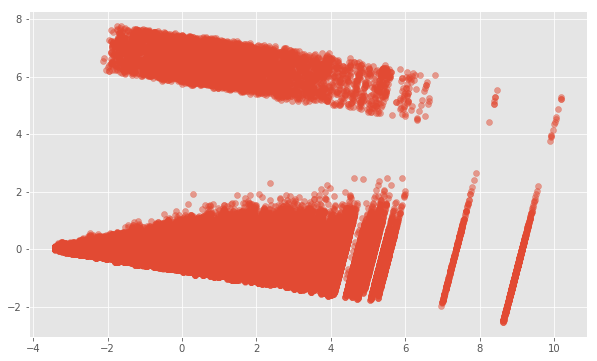

In [195]:
# Visualize the dimension-reduced variables
plt.figure(figsize = (10, 6))
plt.scatter(X_2d.pca1, X_2d.pca2, alpha = 0.5)

Interpreting the components -- this heatmap and the color bar basically represent the correlation between the various feature and the principal component itself.

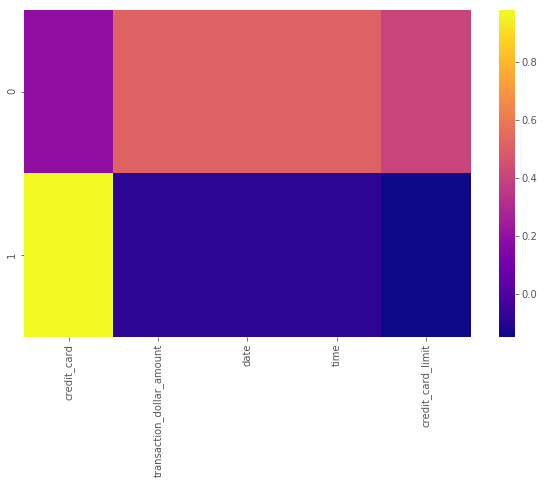

In [196]:
# Visualize this relationship with a heatmap:
df_comp = pd.DataFrame(pca.components_, 
                       columns = ['credit_card', 'transaction_dollar_amount', 'date', 'time', 'credit_card_limit'])

plt.figure(figsize = (10,6))
sns.heatmap(df_comp,cmap = 'plasma',)

## Clustering by K-means


Elbow Method for optimal value of K in KMeans.

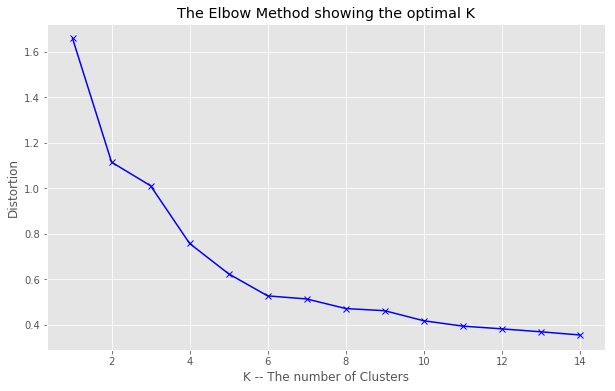

In [197]:
# Determine k, the number of clusters
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters = k).fit(X_2d)
    kmeanModel.fit(X_2d)
    distortions.append(sum(np.min(cdist(X_2d, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_2d.shape[0])

    
# Plot the elbow
plt.figure(figsize = (10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('K -- The number of Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal K')
plt.show()

When K increases, the centroids are closer to the clusters centroids.


The improvements will decline, at some point rapidly, creating the elbow shape.


That point is the optimal value for K. In the image above, K = 6.

In [202]:
# Apply 6 clusters to fit KMeans models
n_clusters = 6
kmeans = KMeans(n_clusters = n_clusters, n_jobs = -1)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## Display the suspicious transactions

In [243]:
# Display the the number of points(transactions) in each cluster
X_2d['label'] = kmeans.labels_
print(X_2d.label.value_counts())
print('suspicious_label:')
print(X_2d.label.value_counts().argmin())

5    107675
0     73489
1     49123
4     33034
3     25831
2      5436
Name: label, dtype: int64
suspicious_label
2


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  """


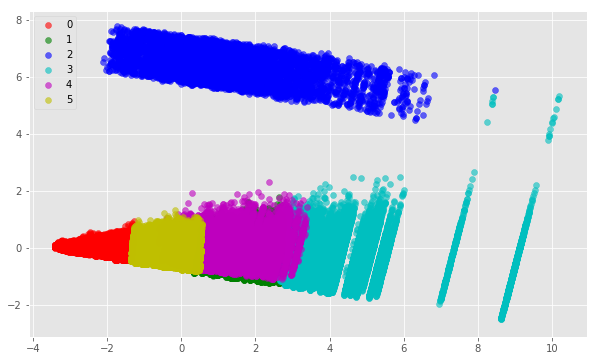

In [207]:
# Visualize the clustering results above
plt.figure(figsize = (10, 6))
colors = iter( ['r','g','b','c','m','y','k'] )

for label in  range(n_clusters) :
    temp = X_2d.loc[X_2d.label == label,:]
    plt.scatter(temp.pca1, temp.pca2, label=label, alpha = 0.6, c = next(colors))

plt.legend(loc = 'best')

In [247]:
# Display suspicious transactions
suspicious_ts = ts_info.loc[X_2d.label == 2, ['credit_card','transaction_dollar_amount',
                              '25%','50%','75%','credit_card_limit','date']]
suspicious_ts.head()

,credit_card,transaction_dollar_amount,25%,50%,75%,credit_card_limit,date
84,1003715054175576,995.35,59.01,93.73,124.63,20000,2015-09-11
145,1003715054175576,818.47,59.01,93.73,124.63,20000,2015-10-01
152,1003715054175576,888.04,59.01,93.73,124.63,20000,2015-10-18
226,1003715054175576,859.31,59.01,93.73,124.63,20000,2015-08-24
246,1003715054175576,925.78,59.01,93.73,124.63,20000,2015-09-24


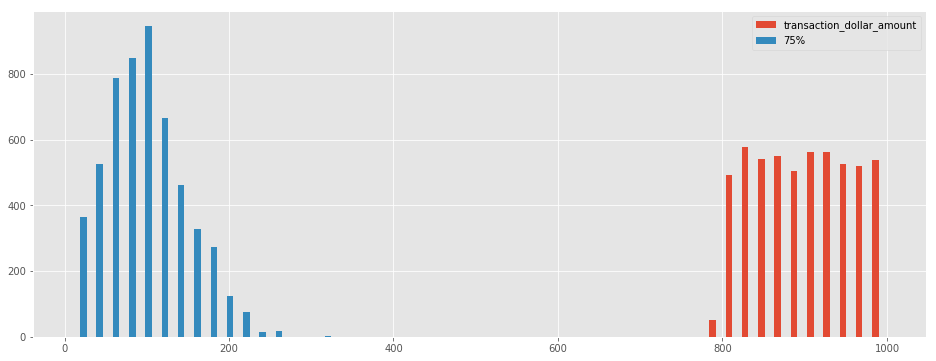

In [258]:
# Visualize the suspicious transactions above
plt.figure(figsize = (16, 6))

labels = ["transaction_dollar_amount",'75%']
plt.hist(suspicious_ts.loc[:, labels].values, bins = 50, label = labels)
plt.legend(loc = 'best')

From the plot above, it's easy to find that the transaction_amount from the suspicious group go far beyond than their 
75th percentile transaction amount, which deserve further invetigation.